# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Logistic Regression</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Softmax</span> </center>

<span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

A custom implementation of Softmax logistic regression.

Link function: $\text{softmax}(g_j(x)) = \frac{e^{g_j(x)}}{\sum_{k=1}^{K} e^{g_k(x)}}$

 Resources used:

- [Multinomial Logistic Regression Model Built from Scratch](https://stackoverflow.com/questions/65201940/improving-accuracy-of-multinomial-logistic-regression-model-built-from-scratch)
- [Softmax Regression](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/softmax-regression.ipynb)
- [Introduction to SGD Classifier](https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/)
- [Practical Guide to Applied Conformal Prediction in Python](https://www.packtpub.com/product/practical-guide-to-applied-conformal-prediction-in-python/9781805122760)

In [1]:
import pandas as pd

# Fetch blended credit data
url = (
    "hhttps://drive.google.com/file/d/1gVpEtge4_D2UB8_pQwnhyPrV2iFbU2-M/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_parquet(url)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.DataFrame(dataset)

colors = ['#4db848', '#fdd619', '#77c5ee', '#f37735', '#724c9f']
class_tags = ['No Delinquency', '30-59 Days', '60-89 Days', '90+ Days']

target_labels = [
    'NumberOfTime30-59DaysPastDueNotWorse', 
    'NumberOfTime60-89DaysPastDueNotWorse', 
    'NumberOfTimes90DaysLate'
    ]

# Revised function to determine the category based on the maximum delinquency
def determine_category(row):
    # Extract the values to simplify logic
    days_30_59 = row['NumberOfTime30-59DaysPastDueNotWorse']
    days_60_89 = row['NumberOfTime60-89DaysPastDueNotWorse']
    days_90 = row['NumberOfTimes90DaysLate']

    # Determine the category based on the maximum value
    max_value = max(days_30_59, days_60_89, days_90)
    if max_value == 0 or max_value not in [days_90, days_60_89, days_30_59]:
        return 0  # No delinquency
    elif max_value == days_90:
        return 3  # Delinquency 90+ days
    elif max_value == days_60_89:
        return 2  # Delinquency 60-89 days
    else:
        return 1  # Delinquency 30-59 days

# Apply the function to each row
df['Category'] = df.apply(determine_category, axis=1)

features = [
    'external_risk_estimate',
    'paid_total',
    'num_historical_failed_to_pay',
    'revolving_utilization_of_unsecured_lines',
    'account_never_delinq_percent',
    'number_real_estate_loans_or_lines',
    'num_trades_60_ever_2_derog_pub_rec',
    'months_since_most_recent_trade_open',
    'num_bank_2_natl_trades_w_high_utilization', 'debt_to_income'
]

X, y = df[features], df['Category']

ix_train, ix_test = train_test_split(X.index, stratify=y, test_size=0.2, random_state=42)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate Gini score from roc auc for each class
def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# Calculate Gini scores for each class and print them
def print_gini_scores(y_true, y_pred, class_tags):
    gini_scores = [gini_score(y_true == i, y_pred[:, i]) for i in range(np.unique(y_true).shape[0])]
    
    for i, gini in enumerate(gini_scores):
        print(f"Gini score for class {class_tags[i]}: {gini:.4f}")

# Calculate and plot learning curve for SGD
def plot_learning_curve(losses, batch_size, title="Learning curve"):
    epoch_losses = [
        np.mean(losses[i : i + batch_size]) for i in range(0, len(losses), batch_size)
    ]
    
    fig = plt.figure(figsize=(4, 4), dpi=150)
    plt.rcParams['font.family'] = 'Arial'
    plt.plot(epoch_losses, color='#77c5ee')
    plt.title(title)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.grid(alpha=0.1)
    plt.ylabel("Log Loss")
    plt.xlabel("Iteration")
    plt.tight_layout()
    plt.show()

# Plot ROC curve for each class
def plot_roc_curve(y_true, y_pred, class_tags, colors, title="ROC curve"):
    fig = plt.figure(figsize=(4, 4), dpi=150)
    for i in range(np.unique(y_true).shape[0]):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
        gini = roc_auc_score(y_true == i, y_pred[:, i]) * 2 - 1
        plt.plot(fpr, tpr, label=f'{class_tags[i]}: {gini:.2%}', color=colors[i])
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(alpha=0.1)
    plt.tight_layout()
    plt.legend()
    plt.show()

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Mini-batch SGD</span>

A custom implementation of Softmax mini-batch SGD and Fisher scoring.

In [4]:
import numpy as np
from sklearn.utils import shuffle


class SoftmaxLogisticRegression(object):
    """
    This implementation of Softmax Logistic Regression
    uses the Fisher Information Matrix to calculate the
    Hessian matrix. The Hessian matrix is then used to
    calculate the weights update.

    We can use batches and adjust the learning rate in
    this implementation.

    Parameters:
    -----------
    learning_rate: float
        The learning rate for the algorithm.
    n_iter: int
        The number of iterations to train the algorithm.
    n_classes: int
        The number of classes in the target variable.
    weights_init: np.ndarray
        The initial weights for the algorithm.
    bias_init: float
        The initial bias for the algorithm.
    use_bias: bool
        Whether to use a bias term in the algorithm.
    regularization: str
        The type of regularization to use. Either 'l1' or 'l2'.
    reg_param: float
        The regularization parameter.
    batch_size: int
        The number of samples to use in each iteration.
    """

    def __init__(
        self,
        learning_rate=0.1,
        n_iter=10,
        n_classes=None,
        weights_init=None,
        bias_init=0.0,
        use_bias=False,
        regularization="l2",
        reg_param=0.001,
        batch_size=1,
        method="fisher",
    ):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.n_classes = n_classes
        self.weights = None
        self.losses = []
        self.weights_init = weights_init
        self.bias_init = bias_init
        self.use_bias = use_bias
        self.regularization = regularization
        self.reg_param = reg_param
        self.batch_size = batch_size
        self.method = method

    def _initialize_weights(self, n_features: int):
        if self.weights_init is None:
            self.weights = np.zeros((n_features, self.n_classes)) # type: ignore
        else:
            self.weights = self.weights_init
        self.bias = np.zeros((1, self.n_classes)) if self.use_bias else None # type: ignore

    def softmax(self, z):
        # Ensure z is a numpy array
        if isinstance(z, (pd.Series, pd.DataFrame)):
            z = z.to_numpy()
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _cross_entropy(self, output, y_target):
        eps = 1e-9
        output = np.clip(output, eps, 1 - eps)
        return -np.sum(np.log(output) * y_target, axis=1)

    def _cost(self, cross_entropy):
        return np.mean(cross_entropy)

    def _add_regularization(self, gradient):
        if self.regularization == "l1":
            # Apply L1 regularization
            if self.use_bias:
                gradient[:-1] -= self.reg_param * np.sign(self.weights[:-1]) # type: ignore
            else:
                gradient -= self.reg_param * np.sign(self.weights) # type: ignore
        elif self.regularization == "l2":
            # Apply L2 regularization
            if self.use_bias:
                gradient[:-1] -= 2 * self.reg_param * self.weights[:-1] # type: ignore
            else:
                gradient -= 2 * self.reg_param * self.weights # type: ignore
        return gradient

    def _one_hot(self, y, n_labels):
        mat = np.zeros((len(y), n_labels))
        mat[np.arange(len(y)), y] = 1
        return mat

    def fit(self, X, y):
        _, n_features = X.shape
        n_classes = len(np.unique(y)) if self.n_classes is None else self.n_classes
        self._initialize_weights(n_features + (1 if self.use_bias else 0))

        for _ in range(self.n_iter):
            X, y = shuffle(X, y, random_state=42)
            for i in range(0, X.shape[0], self.batch_size): # type: ignore
                xi_batch = X[i : i + self.batch_size]
                yi_batch = y[i : i + self.batch_size]
                if self.use_bias:
                    xi_batch = np.hstack([xi_batch, np.ones((xi_batch.shape[0], 1))])
                z = xi_batch @ self.weights  # type: ignore
                p = self.softmax(z)
                label = self._one_hot(yi_batch, n_classes)
                diff = p - label
                # Gradient of the log likelihood
                gradient = np.dot(xi_batch.T, diff)
                gradient = self._add_regularization(gradient)
                if self.method == "fisher":
                    # Fisher Information Matrix
                    design_matrix = xi_batch.T.dot(xi_batch)
                    FIM = np.linalg.pinv(design_matrix * np.sum(p.T.dot(1 - p)))
                    self.weights -= self.learning_rate * FIM @ gradient
                elif self.method == "sgd":
                    self.weights -= self.learning_rate * gradient
                else:
                    raise ValueError("Method must be 'fisher' or 'sgd'.")
                loss = self._cross_entropy(p, label)
                self.losses.append(self._cost(loss))

    def predict_proba(self, X):
        if self.use_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        z = X @ self.weights # type: ignore
        return self.softmax(z)

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Mini-batch SGD</span>

Mini-batch SGD softmax logistic regression.

In [37]:
# fit the softmax regression model
softmax_regression = SoftmaxLogisticRegression(
    n_classes=4, 
    learning_rate=1e-9,
    n_iter=10_000,
    regularization='l1',
    reg_param=0.05,
    batch_size=100,
    use_bias=True,
    method='sgd'
)

softmax_regression.fit(X.loc[ix_train], y.loc[ix_train])

Gini score for class No Delinquency: 0.3069
Gini score for class 30-59 Days: 0.2018
Gini score for class 60-89 Days: 0.2938
Gini score for class 90+ Days: 0.4181


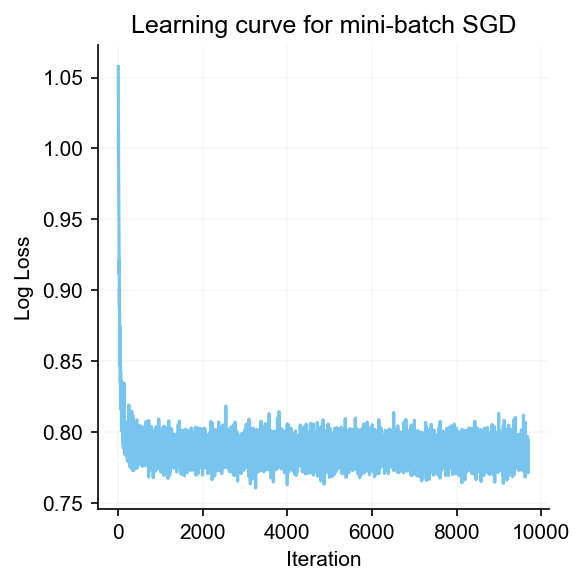

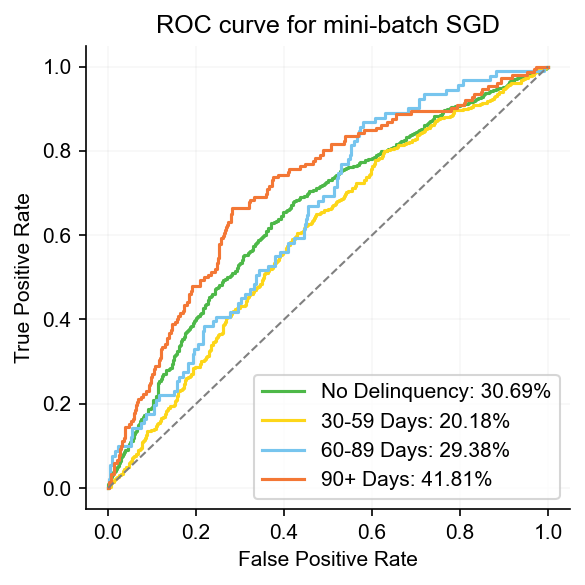

In [38]:
y_pred = softmax_regression.predict_proba(X.loc[ix_test])

# Print Gini scores
print_gini_scores(y.loc[ix_test], y_pred, class_tags)
plot_learning_curve(
    softmax_regression.losses, X.shape[0] // softmax_regression.batch_size, 
    title='Learning curve for mini-batch SGD'
)
plot_roc_curve(y.loc[ix_test], y_pred, class_tags, colors, title='ROC curve for mini-batch SGD')

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Fisher scoring</span>
Fisher scoring algorithm allows to improve model performance due to faster convergence.

In [39]:
# fit the softmax regression model
softmax_regression = SoftmaxLogisticRegression(
    n_classes=4, 
    learning_rate=1e-1,
    n_iter=500,
    regularization='l2',
    reg_param=0.01,
    batch_size=135,
    use_bias=True,
    method='fisher',
)

softmax_regression.fit(X.loc[ix_train], y.loc[ix_train])

Gini score for class No Delinquency: 0.5038
Gini score for class 30-59 Days: 0.3357
Gini score for class 60-89 Days: 0.4977
Gini score for class 90+ Days: 0.6090


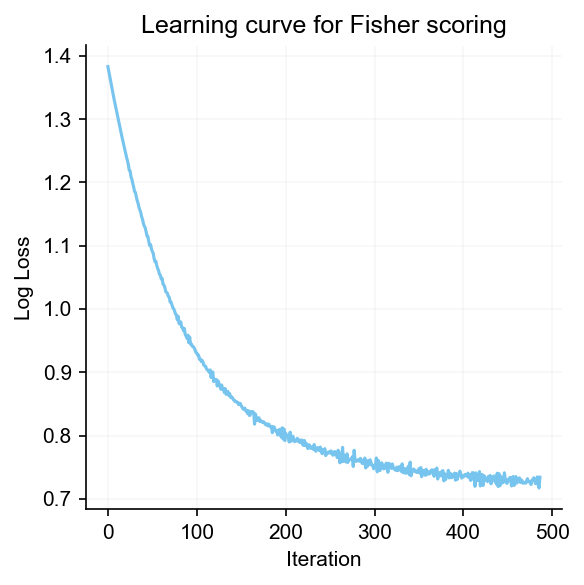

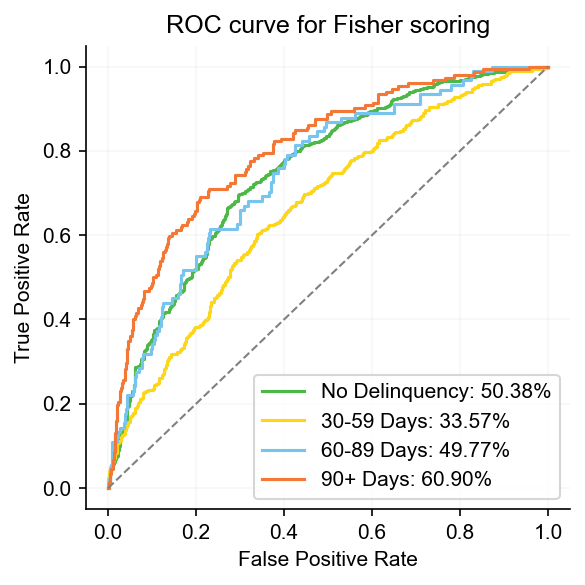

In [40]:
y_pred = softmax_regression.predict_proba(X.loc[ix_test])

# Print Gini scores
print_gini_scores(y.loc[ix_test], y_pred, class_tags)

# Plot learning curve
plot_learning_curve(
    softmax_regression.losses, 
    X.shape[0] // softmax_regression.batch_size, 
    title='Learning curve for Fisher scoring'
)

# Plot ROC curve
plot_roc_curve(
    y.loc[ix_test], 
    y_pred, 
    class_tags, 
    colors, 
    title='ROC curve for Fisher scoring'
)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Weight of Evidence (WOE)</span>

Add some generative aspect to the model. We will use WOE binning for each iteration.

In [54]:
from optbinning import BinningProcess

binning_process = BinningProcess(
    variable_names=X.columns.tolist(),
    max_pvalue=0.5,
)

binning_process.fit(X.loc[ix_train], y.loc[ix_train])
X_train = binning_process.transform(X.loc[ix_train])
X_test = binning_process.transform(X.loc[ix_test])

softmax_woe_model = SoftmaxLogisticRegression(
    n_classes=4,
    learning_rate=2e-0,
    n_iter=500,
    regularization='l1',
    reg_param=0.01,
    batch_size=700,
    use_bias=True,
    method='fisher'
)

softmax_woe_model.fit(X_train, y.loc[ix_train])

Gini score for class No Delinquency: 0.5300
Gini score for class 30-59 Days: 0.3671
Gini score for class 60-89 Days: 0.4856
Gini score for class 90+ Days: 0.6153


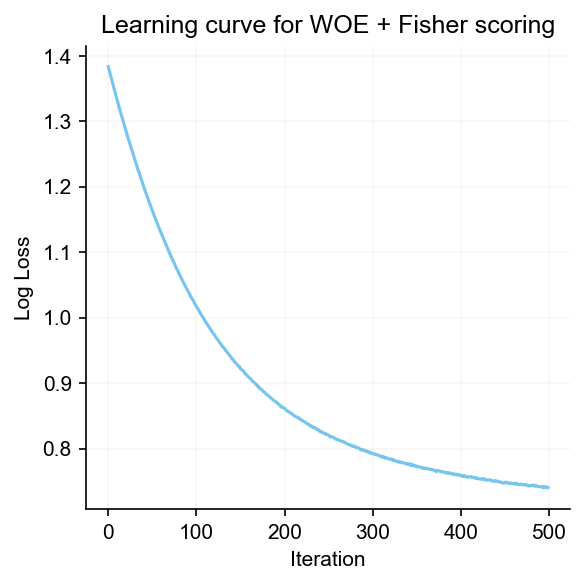

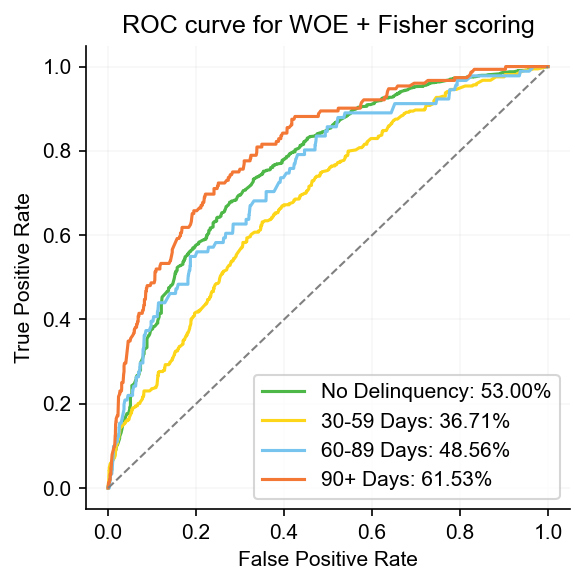

In [55]:
y_pred = softmax_woe_model.predict_proba(X_test)

# Print Gini scores
print_gini_scores(y.loc[ix_test], y_pred, class_tags)

# Plot learning curve
plot_learning_curve(
    softmax_woe_model.losses,
    X.shape[0] // softmax_woe_model.batch_size, 
    title='Learning curve for WOE + Fisher scoring'
)

# Plot ROC curve
plot_roc_curve(
    y.loc[ix_test],
    y_pred,
    class_tags,
    colors,
    title='ROC curve for WOE + Fisher scoring'
)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Conformal prediction</span>
Quantifying uncertainty around the model's predictions.

In [291]:
import numpy as np

# Step 1: Divide training data into two disjoint sets I_T and I_C
np.random.seed(42)
indices = np.random.permutation(len(ix_train))
split_point = int(0.5 * len(indices))

I_T = indices[:split_point]
I_C = indices[split_point:]

# Train point prediction model H using H_T
H_T = softmax_regression.predict_proba(X.loc[ix_train].iloc[I_T])


# Compute alpha for each class separately
def compute_alpha(y_true, y_pred):
    scores = np.zeros_like(y_pred)
    # Regret score
    scores[np.arange(len(y_true)), y_true] = np.abs(
        y_true - y_pred[np.arange(len(y_true)), y_true]
    )
    return np.mean(scores, axis=0)


alpha = compute_alpha(y.loc[ix_train].iloc[I_C], H_T)
print("Alpha scores for each class:", alpha)

# Compute conformity scores for the first few test instances
conformity_scores = []
for x in X.loc[ix_test].iloc[:10].values:
    y_pred = softmax_regression.predict_proba(x.reshape(1, -1))
    conformity_scores.append(compute_alpha(np.argmax(y_pred, axis=1), y_pred))

print("Conformity scores for the first 10 test instances:")
for i, score in enumerate(conformity_scores):
    print(f"Instance {i+1}: {score}")

# Compute threshold for 95% coverage
predictions = softmax_regression.predict_proba(X.loc[ix_train].iloc[I_C])
prob_true_class = predictions[
    np.arange(len(y.loc[ix_train].iloc[I_C])), y.loc[ix_train].iloc[I_C]
]
n = len(prob_true_class)
qhat = np.quantile(1 - prob_true_class, 0.95 * (n + 1) / n)
print("Computed threshold (qhat):", qhat)

# Create prediction sets for the first few test instances
predictions_new = softmax_regression.predict_proba(X.loc[ix_test].iloc[:10])
prediction_sets = (1 - predictions_new <= qhat).astype(int)
print("Prediction sets for the first 10 test instances:")
print(prediction_sets)

Alpha scores for each class: [0.52340066 0.13512547 0.07109576 0.19911643]
Conformity scores for the first 10 test instances:
Instance 1: [0.86599931 0.         0.         0.        ]
Instance 2: [0.75952805 0.         0.         0.        ]
Instance 3: [0.5052174 0.        0.        0.       ]
Instance 4: [0.53013105 0.         0.         0.        ]
Instance 5: [0.77026603 0.         0.         0.        ]
Instance 6: [0.81445975 0.         0.         0.        ]
Instance 7: [0.86995999 0.         0.         0.        ]
Instance 8: [0.64396198 0.         0.         0.        ]
Instance 9: [0.84461714 0.         0.         0.        ]
Instance 10: [0.51893868 0.         0.         0.        ]
Computed threshold (qhat): 0.919905152815725
Prediction sets for the first 10 test instances:
[[1 0 0 0]
 [1 1 0 0]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 1 0 1]
 [1 0 0 0]
 [1 1 1 1]]


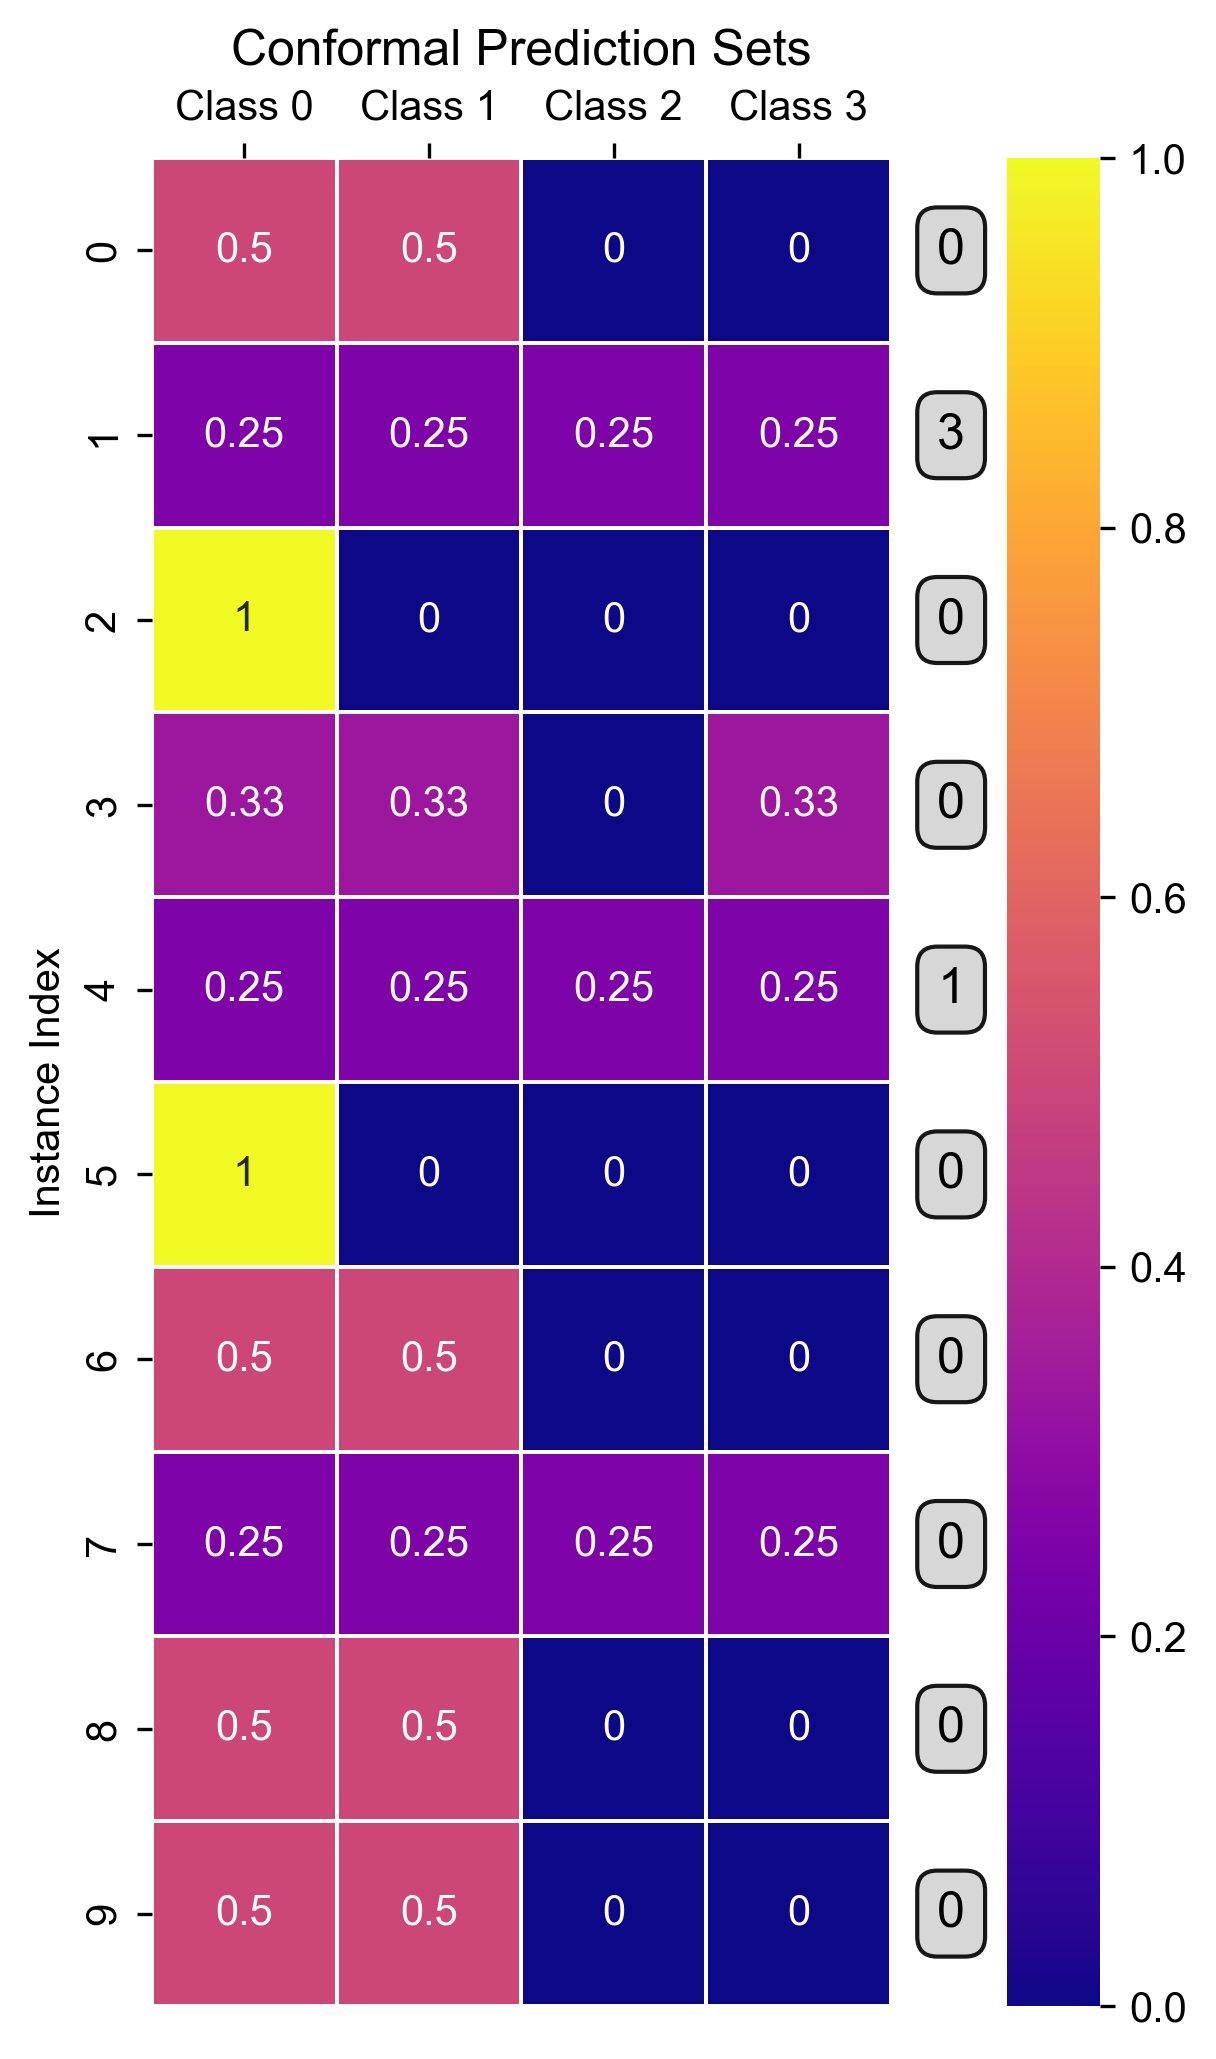

In [294]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format = 'retina'

# sample a random batch of 20
ix_sample = ix_test.to_frame().sample(10, replace=True, random_state=42).index

predictions_new = softmax_regression.predict_proba(X.loc[ix_sample])
prediction_sets = (1 - predictions_new <= qhat).astype(int)
prediction_sets = prediction_sets / prediction_sets.sum(axis=1, keepdims=True)

# Create a DataFrame for visualization
df = pd.DataFrame(
    data=prediction_sets, columns=[f'Class {i}' for i in range(prediction_sets.shape[1])]
)
true_label = y.loc[ix_sample].values

# Plot heatmap
plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(df, cmap='plasma', cbar=True, annot=True, linewidths=0.5, linecolor='white')

# Annotate with true class labels
for i, true_label in enumerate(true_label):
    plt.text(
        prediction_sets.shape[1] + 0.25, i + 0.5, 
        f'{true_label}',
        ha='left',
        va='center',
        fontsize=12,
        weight='normal',
        color='black',
        bbox=dict(
            facecolor='lightgray', 
            alpha=0.9, 
            edgecolor='black', 
            boxstyle='round,pad=0.4'
        )
    )

# Set axis labels and title
plt.ylabel('Instance Index')
plt.title('Conformal Prediction Sets')

# Set equal width for each cell
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position("top")

plt.show()